In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [4]:
from soundsig.sound import BioSound 

### Collect data

In [5]:
DATASET_ID = 'swamp_sparrow'

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-pad.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/swamp_sparrow/swampsparrow-pad.pickle')

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df["syll_len"] = syllable_df.end_time - syllable_df.start_time

In [9]:
len(syllable_df)

97528

In [10]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram,syll_len
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[-0.0, 9.530822842799384e-05, 0.00046982690049...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0145
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,"[0.0, -0.0003121317332160884, -0.0008303958537...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0635
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.0, 0.0014956086103258461, 0.003453462802130...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0110


In [11]:
syllable_df['nsamp'] = [len(row.audio) for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df))]

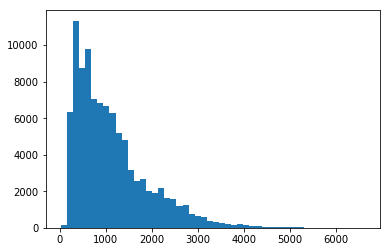

In [12]:
plt.hist(syllable_df['nsamp'].values, bins=50);

In [13]:
import IPython.display as ipd

In [14]:
import noisereduce as nr

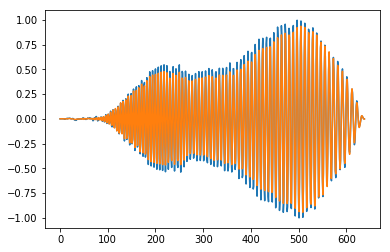

In [15]:
for idx, row in tqdm(syllable_df[:10].iterrows(), total=len(syllable_df)):
    
    audio = row.audio
    nraudio = nr.reduce_noise(audio_clip=audio, n_std_thresh=0.5, win_length=512, n_fft = 512,hop_length=32, verbose=False)
    plt.plot(audio)
    plt.plot(nraudio)
    break

In [16]:
from avgn.signalprocessing.spectrogramming import (
    spectrogram, melspectrogram, inv_spectrogram, _build_mel_basis,
    _build_mel_inversion_basis, spectrogram_librosa, inv_spectrogram_librosa, _mel_to_linear)
from avgn.utils.hparams import HParams
from IPython.display import display, Audio

In [20]:
import librosa

In [21]:
mel_lower_edge_hertz=1000
mel_upper_edge_hertz=22000
num_mel_bins = 32
num_freq = 1024
fs = 44100.0

In [22]:
_mel_basis = librosa.filters.mel(
        fs,
        num_freq,
        n_mels=num_mel_bins,
        fmin=mel_lower_edge_hertz, 
        fmax=mel_upper_edge_hertz,
    )

In [23]:
_mel_inversion_basis = _build_mel_inversion_basis(_mel_basis)

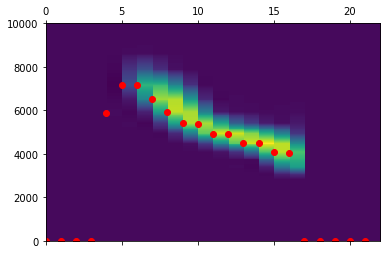

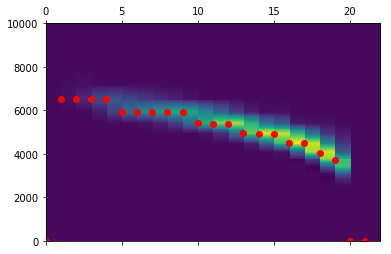

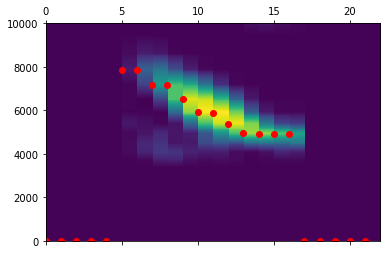

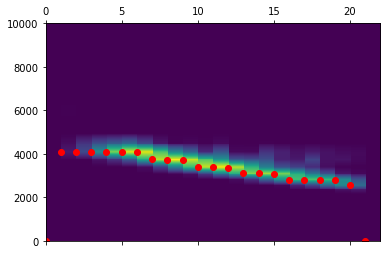

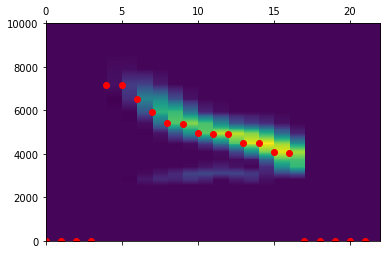

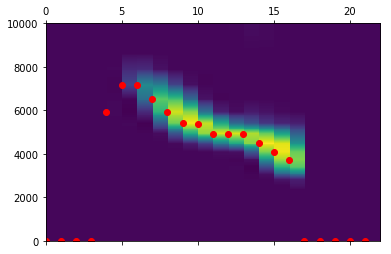

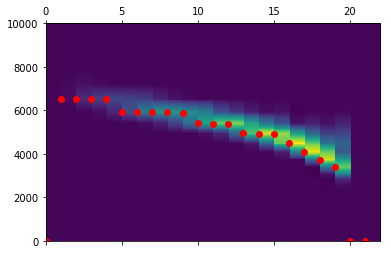

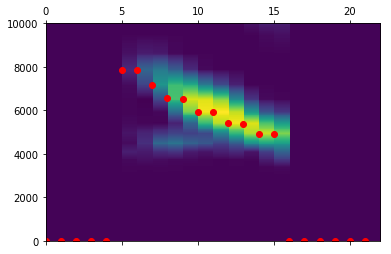

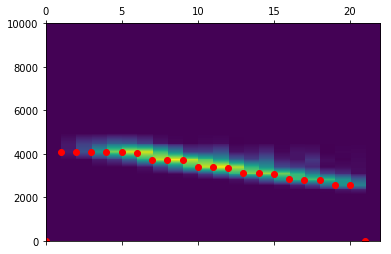

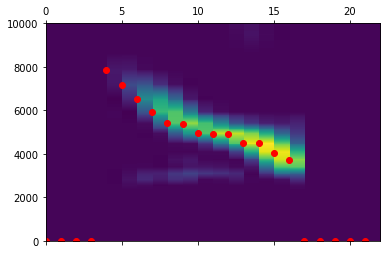

In [24]:
for idx, row in tqdm(syllable_df[:10].iterrows(), total=len(syllable_df)):
    mel_inv_spec = _mel_to_linear(row.spectrogram, _mel_inverse_basis = _mel_inversion_basis)
    fmax = np.argmax(mel_inv_spec, axis=0)
    fmax = fmax * fs / (num_freq) 
    f_high, f_low = fmax[fmax != 0][[0, -1]]
    
    fig, ax = plt.subplots()
    ax.matshow(mel_inv_spec, origin="lower", aspect="auto", extent = [0, len(fmax), 0, fs/2])
    ax.scatter(np.arange(len(fmax)), fmax, color='red')
    ax.set_ylim([0, 10000])
    ax.set_xlim([0, len(fmax)])
    plt.show()

In [25]:
fh_list = []
fl_list = []
for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df)):
    mel_inv_spec = _mel_to_linear(row.spectrogram, _mel_inverse_basis = _mel_inversion_basis)
    fmax = np.argmax(mel_inv_spec, axis=0)
    fmax = fmax * fs / (num_freq) 
    f_high, f_low = fmax[fmax != 0][[0, -1]]
    fh_list.append(f_high)
    fl_list.append(f_low)

In [26]:
syllable_df['f_high'] = fh_list
syllable_df['f_low'] = fl_list

In [27]:
syllable_df['f_diff'] = syllable_df['f_high'] - syllable_df['f_low']

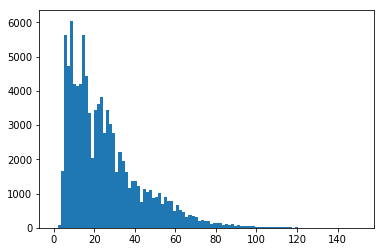

In [28]:
plt.hist(syllable_df['syll_len'].values * 1000, bins=100);

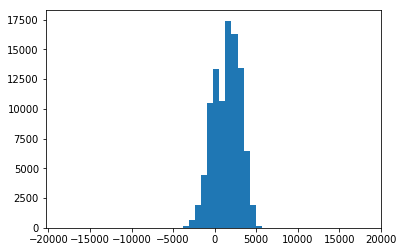

In [29]:
plt.hist(syllable_df['f_diff'].values, bins=50);

In [35]:
syllable_df['place'] = [i[:2] for i in  syllable_df.indv]

In [36]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram,syll_len,nsamp,f_high,f_low,f_diff,place
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[-0.0, 9.530822842799384e-05, 0.00046982690049...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0145,639,5900.097656,4048.242188,1851.855469,NY
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,"[0.0, -0.0003121317332160884, -0.0008303958537...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0635,2800,6503.027344,3703.710938,2799.316406,NY
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.0, 0.0014956086103258461, 0.003453462802130...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0110,485,7838.085938,4909.570312,2928.515625,NY


In [37]:
subset_df = syllable_df[syllable_df.place == 'NY']

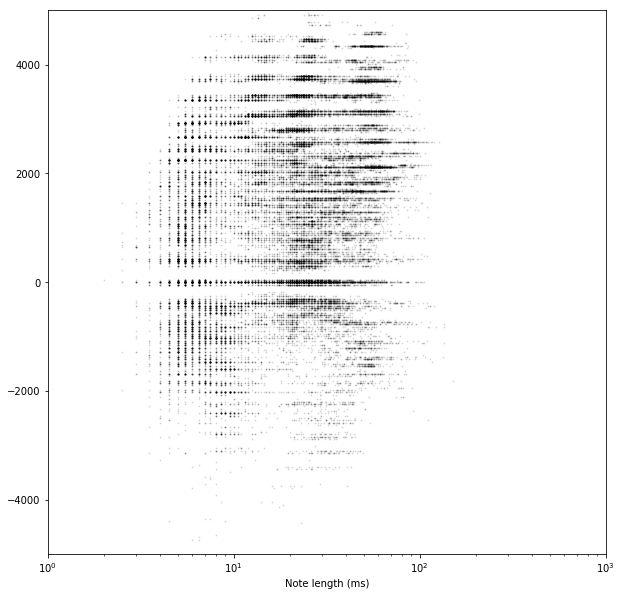

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(subset_df['syll_len'].values * 1000, subset_df['f_diff'], s = 1, color='k', alpha = 0.1)
ax.set_xlabel('Note length (ms)')
ax.set_xlim([1, 1000])
ax.set_ylim([-5000, 5000])
ax.set_xscale('log')
plt.show()

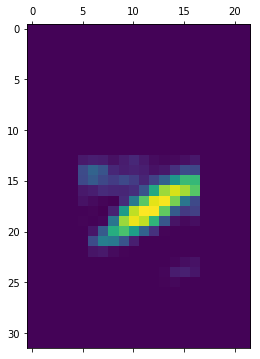

In [390]:
plt.matshow(syllable_df[syllable_df['f_diff'] < 0].spectrogram.values[0])